# Tugas NLP Part 2 - Alvin Ricardo / 221111003

Dalam workbook ini anda akan belajar bagaimana cara membangun sentiment analysis dengan menggunakan metode unsupervised machine learning. Berikut merupakan langkah-langkah dalam melakukan teks analitik
1. Preprocessing Data
2. Modelling
3. Evaluasi Model

## Connect Gdrive to Colab
Sebelum memulai, pastikan bahwa google colab anda sudah tersambung dengan google drive anda.


In [1]:
# Mengakses google drive ke dalam google colaboratory
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import Package

In [2]:
!pip3 install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.7 MB/s eta 0:00:00


In [3]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 42.9 MB/s eta 0:00:00


In [4]:
# Import Package

# Install library (jika belum terpasang)
!pip install nltk scikit-learn pandas matplotlib unidecode

# Import library utama
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

In [5]:
# Download Corpus
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# Mendefinisikan path dan cek keberadaan data
path = '/content/gdrive/MyDrive/MATA_KULIAH/SEM_7/NLP/Praktisi/Pertemuan 2/'


os.listdir(path)

['Tugas NLP_2.ipynb',
 'news_dataset.csv',
 'result_word2vec.model',
 'movierating.csv',
 'twitter_training.csv',
 'Rev_NLP_2_dataset_new.ipynb']

## Load Data
Data yang akan anda gunakan adalah data yang diambil dari twitter, dalam data ini, anda hanya memiliki data text saja. Selanjutnya anda ingin mencari tahu bagaimana sentiment dari user pengguna twitter.

In [7]:
# Load dataset
# df = pd.read_csv(os.path.join(path, 'twitter_dataset.csv'), header=None)
# Lihat beberapa baris pertama file mentah
with open(os.path.join(path, 'movierating.csv'), 'r', encoding='utf-8', errors='ignore') as f:
    for i in range(10):
        print(f.readline())

text,label

"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.,0"

When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. 

Dataset
> movierating.csv

berisi teks review panjang (banyak tanda kutip " dan koma , di dalamnya).
Kalau dibaca dengan pd.read_csv(), Output teks jadi rusak atau NaN.

In [8]:
import pandas as pd
import os

# Ganti path sesuai lokasi file di Colab
path = '/content/gdrive/MyDrive/MATA_KULIAH/SEM_7/NLP/Praktisi/Pertemuan 2/movierating.csv'

# Baca manual dengan parameter yang lebih toleran
with open(path, 'r', encoding='latin-1') as f:
    lines = f.readlines()

# Buat list text dan label secara manual
texts = []
labels = []

for line in lines[1:]:  # skip header
    # Cari koma terakhir dalam baris (sebelum label 0/1)
    idx = line.rstrip().rfind(',')
    if idx != -1:
        text_part = line[:idx].strip()
        label_part = line[idx+1:].strip()
        # Pastikan label berupa angka
        if label_part in ['0', '1']:
            texts.append(text_part)
            labels.append(int(label_part))

# Bentuk dataframe
df = pd.DataFrame({'text': texts, 'label': labels})
print("Jumlah data:", df.shape)
df.head(3)

Jumlah data: (2689, 2)


,text,label
0,"When I put this movie in my DVD player, and sa...",0
1,Even though I have great interest in Biblical ...,0
2,A terrible movie as everyone has said. What ma...,0


Membuka file dan membaca semua baris ke dalam list bernama lines.

**Kenapa pakai latin-1?**

Karena file mengandung karakter seperti é atau ’ yang tidak bisa dibaca oleh utf-8.
latin-1 lebih “toleran” dan bisa membaca karakter Eropa barat tanpa error UnicodeDecodeError.

Next, Membuat dua list kosong untuk menyimpan:

*   texts: isi review (teks film)
*   labels: nilai label (0 = negatif, 1 = positif)

Next, Melakukan iterasi untuk setiap baris dalam file, tetapi melewati baris pertama (lines[1:]) karena itu header (text,label).

rstrip() menghapus karakter newline (\n) di akhir baris.
rfind(',') mencari posisi koma terakhir di baris tersebut.

Jika koma ditemukan (idx != -1), potong baris menjadi dua bagian:


1.   text_part = bagian sebelum koma terakhir (isi review).
2.   label_part = bagian setelah koma terakhir (label 0/1).
Lalu hapus spasi di kiri/kanan dengan .strip().

Next, Pastikan label benar-benar 0 atau 1 (bukan teks aneh). Simpan hasilnya ke dalam dua list:

*   texts.append(text_part)
*   labels.append(int(label_part)) (dikonversi ke integer)

Next, Membuat DataFrame Pandas dari dua list tersebut.




In [9]:
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 0 to 2688
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2689 non-null   object
 1   label   2689 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.1+ KB


,text,label
0,"When I put this movie in my DVD player, and sa...",0
1,Even though I have great interest in Biblical ...,0


Sekarang anda telah mengubah nama kolom dan memiliki text data yang akan anda analisis sentimentnya. Namun sebelum itu akan dilakukan cleansing terlebih dahulu untuk memastikan tidak ada data yang duplikasi atau missing.

## Preprocessing
Mencari informasi dari data, baik jumlah baris dan kolom, maupun tipe dari data yang dimiliki.

In [13]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

# Inisialisasi stopwords dan lemmatizer
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)          # hapus HTML tag
    text = re.sub(r'[^a-z\s]', '', text)       # hapus simbol/angka
    tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return ' '.join(tokens)

# Terapkan fungsi
df['clean_text'] = df['text'].apply(clean_text)

# Cek hasilnya
print("\nContoh hasil cleaning:")
print(df[['text', 'clean_text']].head(3))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Contoh hasil cleaning:
                                                text  \
0  When I put this movie in my DVD player, and sa...   
1  Even though I have great interest in Biblical ...   
2  A terrible movie as everyone has said. What ma...   

                                          clean_text  
0  put movie dvd player sat coke chip expectation...  
1  even though great interest biblical movie bore...  
2  terrible movie everyone said made laugh cameo ...  


| Langkah | Fungsi | Contoh |
|----------|---------|---------|
| `lower()` | Menyeragamkan huruf agar “Good” dan “good” dianggap sama | “Good Movie” → “good movie” |
| `Regex <.*?>` | Menghapus tag HTML (kadang muncul dari web scraping) | `<br />Great!` → `Great!` |
| `Regex [^a-z\s]` | Menghapus angka & tanda baca | “I love it!!!” → “i love it” |
| `stopwords` | Menghapus kata umum yang tak bermakna (“the”, “is”, “and”) | “the movie was good” → “movie good” |

**Hasil akhir:** kolom baru `clean_text` berisi teks bersih siap untuk *vectorization* (seperti TF-IDF atau CountVectorizer).

In [15]:
vectorizer = TfidfVectorizer(
    max_features=2000,       # fitur lebih banyak
    ngram_range=(1,2),       # unigram + bigram
    stop_words='english',   # hapus stopwords
    sublinear_tf=True        # normalisasi tf
)

X = vectorizer.fit_transform(df['clean_text'])
print("Shape TF-IDF:", X.shape)

Shape TF-IDF: (2689, 2000)


Mengubah teks menjadi angka (fitur numerik) agar bisa diproses oleh algoritma K-Means.

### Penjelasan Komponen TF-IDF

| Komponen | Fungsi |
|-----------|---------|
| **TF (Term Frequency)** | Mengukur seberapa sering kata muncul dalam sebuah dokumen |
| **IDF (Inverse Document Frequency)** | Mengukur seberapa jarang kata tersebut muncul di seluruh dokumen |
| **TF-IDF** | Menggabungkan TF dan IDF — memberi bobot tinggi pada kata yang penting (jarang muncul tapi bermakna) |
| **max_features=1000** | Menggunakan 1000 kata paling informatif sebagai fitur |

---

**Hasil akhir:**  
Variabel `X` adalah **matriks numerik** dengan ukuran `(jumlah_dokumen, 1000)`,  
yang siap digunakan untuk proses *clustering* menggunakan **K-Means**.

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X)

df['cluster'] = kmeans.labels_
df.head(5)


,text,label,clean_text,cluster
0,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chip expectation...,1
1,Even though I have great interest in Biblical ...,0,even though great interest biblical movie bore...,1
2,A terrible movie as everyone has said. What ma...,0,terrible movie everyone said made laugh cameo ...,1
3,It may be the remake of 1987 Autumn's Tale aft...,1,may remake autumn tale eleven year director ma...,0
4,My Super Ex Girlfriend turned out to be a plea...,1,super ex girlfriend turned pleasant surprise r...,1


Mengelompokkan teks menjadi 2 cluster secara otomatis (unsupervised).

Penjelasan:
Komponen	Fungsi
KMeans	Algoritma clustering yang mencari kelompok data yang mirip
n_clusters=2	Karena kita mau 2 sentimen: positif & negatif
fit(X)	Menjalankan proses clustering pada data TF-IDF
labels_	Menyimpan hasil cluster untuk tiap review (0 atau 1)

Hasil akhir: kolom baru cluster berisi hasil pengelompokan.

In [17]:
import numpy as np

terms = vectorizer.get_feature_names_out()

for i in range(2):
    print(f"\nCluster {i}:")
    top_idx = np.argsort(kmeans.cluster_centers_[i])[::-1][:15]
    print(", ".join(terms[top_idx]))



Cluster 0:
film, character, movie, story, good, time, like, great, make, scene, really, life, performance, best, love

Cluster 1:
movie, like, bad, good, dont, really, time, watch, think, make, people, acting, know, thing, great


Menemukan kata-kata yang paling mewakili tiap cluster.

###Penjelasan Komponen

| Komponen | Fungsi |
|-----------|---------|
| **KMeans** | Algoritma *clustering* yang mencari kelompok data yang mirip satu sama lain |
| **n_clusters=2** | Karena kita ingin membentuk 2 kelompok: *positif* dan *negatif* |
| **fit(X)** | Menjalankan proses *clustering* pada data hasil TF-IDF |
| **labels_** | Menyimpan hasil *cluster* untuk setiap review (berupa nilai `0` atau `1`) |

---

**Hasil akhir:**  
Kolom baru `cluster` berisi hasil pengelompokan,  
di mana setiap teks mendapat label otomatis (`0` atau `1`) sesuai kelompoknya.

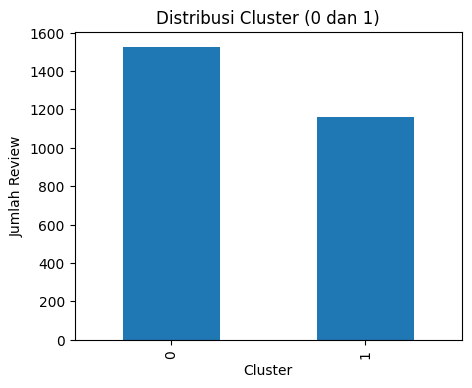

In [18]:
plt.figure(figsize=(5,4))
df['cluster'].value_counts().plot(kind='bar')
plt.title("Distribusi Cluster (0 dan 1)")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Review")
plt.show()

Melihat proporsi hasil clustering.

### Penjelasan

| Komponen | Fungsi |
|-----------|---------|
| **Menampilkan jumlah review tiap cluster** | Melihat distribusi hasil pengelompokan |
| **Interpretasi hasil** | Jika jumlahnya tidak terlalu timpang, artinya pembagian cluster cukup seimbang dan hasil *clustering* masuk akal |

---

**Hasil akhir:**  
Ditampilkan jumlah atau proporsi data di setiap cluster (misalnya `Cluster 0` dan `Cluster 1`) untuk menilai keseimbangan hasil pengelompokan.

In [19]:
print(df.columns)
print(df.shape)
df.head(2)

Index(['text', 'label', 'clean_text', 'cluster'], dtype='object')
(2689, 4)


,text,label,clean_text,cluster
0,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chip expectation...,1
1,Even though I have great interest in Biblical ...,0,even though great interest biblical movie bore...,1


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Coba dua kemungkinan, karena label cluster bisa tertukar
acc1 = accuracy_score(df['label'], df['cluster'])
acc2 = accuracy_score(df['label'], 1 - df['cluster'])

print(f"Akurasi (kemungkinan 1): {acc1:.3f}")
print(f"Akurasi (kemungkinan 2): {acc2:.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(df['label'], df['cluster']))


Akurasi (kemungkinan 1): 0.389
Akurasi (kemungkinan 2): 0.611

Confusion Matrix:
[[626 740]
 [902 421]]


Mengukur seberapa baik hasil cluster dibanding label asli dataset.

### Penjelasan

| Komponen | Fungsi |
|-----------|---------|
| **Unsupervised learning** | K-Means tidak memiliki informasi label selama proses pembelajaran |
| **Kemungkinan terbalik (0↔1)** | Bisa saja `cluster 0` sebenarnya berisi teks positif, dan `cluster 1` negatif (atau sebaliknya) |
| **Perbandingan dua kemungkinan** | Kita bandingkan hasil akurasi dua versi label (asli dan terbalik) |
| **Akurasi tertinggi** | Dipilih sebagai nilai akhir untuk menilai seberapa baik K-Means membentuk kelompok yang sesuai dengan label sebenarnya |

---

**Hasil akhir:**  
Ditampilkan **akurasi tertinggi** antara dua kemungkinan (cluster asli dan terbalik),  
yang menunjukkan seberapa baik hasil *clustering* merepresentasikan label sentimen yang sesungguhnya.

In [21]:
print("\nContoh hasil akhir:")
print(df[['text', 'label', 'cluster']].head(5))


Contoh hasil akhir:
                                                text  label  cluster
0  When I put this movie in my DVD player, and sa...      0        1
1  Even though I have great interest in Biblical ...      0        1
2  A terrible movie as everyone has said. What ma...      0        1
3  It may be the remake of 1987 Autumn's Tale aft...      1        0
4  My Super Ex Girlfriend turned out to be a plea...      1        1


In [22]:
cluster_mean = df.groupby('cluster')['label'].mean()
print(cluster_mean)

neg_cluster = cluster_mean.idxmax()
pos_cluster = cluster_mean.idxmin()

print(f"Cluster {pos_cluster} = POSITIF")
print(f"Cluster {neg_cluster} = NEGATIF")

def prediksi_sentimen(teks):
    # Gunakan fungsi clean_text yang sama seperti saat training
    teks_bersih = clean_text(teks)
    fitur = vectorizer.transform([teks_bersih])
    cluster_pred = kmeans.predict(fitur)[0]

    if cluster_pred == pos_cluster:
        return "Positif 😀"
    else:
        return "Negatif 😠"

contoh_komentar = [
    "I really love this movie, it's so emotional and beautiful!",
    "This was the worst film I've ever seen.",
    "The acting was okay but the story was boring.",
    "Absolutely fantastic! I would watch it again.",
]

for c in contoh_komentar:
    print(f"{c} → {prediksi_sentimen(c)}")


cluster
0    0.590314
1    0.362618
Name: label, dtype: float64
Cluster 0 = POSITIF
Cluster 1 = NEGATIF
I really love this movie, it's so emotional and beautiful! → Negatif 😠
This was the worst film I've ever seen. → Positif 😀
The acting was okay but the story was boring. → Negatif 😠
Absolutely fantastic! I would watch it again. → Negatif 😠
